# InceptionV3 Model for Cell Classification

This notebook implements an InceptionV3-based deep learning model for classifying cell images into tumor, non-tumor, and empty categories.

## Setup and Imports

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import pandas as pd
import shutil
from collections import defaultdict

# Set GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU devices and enabled memory growth")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")


SEED = 3888
def set_seed(seed=3888):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

# Define image size and batch size
IMG_SIZE = 224  # Standard input size for ResNet50
BATCH_SIZE = 32

Found 1 GPU devices and enabled memory growth


## Data Preparation

In [2]:
type_to_label_map = {
    'Non-Tumor': 0,
    'Tumor': 1,
    'Empty': 2
}

In [3]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    
    return img_array

In [4]:
# Define function to get the four quadrants of an image
def get_quadrant_crop(img, quadrant):
    w, h = img.size
    if quadrant == 'Q1':  # Top-left quadrant
        return img.crop((0, 0, w//2, h//2)), (0, 0, w//2, h//2)
    elif quadrant == 'Q2':  # Top-right quadrant
        return img.crop((w//2, 0, w, h//2)), (w//2, 0, w, h//2)
    elif quadrant == 'Q3':  # Bottom-left quadrant
        return img.crop((0, h//2, w//2, h)), (0, h//2, w//2, h)
    elif quadrant == 'Q4':  # Bottom-right quadrant
        return img.crop((w//2, h//2, w, h)), (w//2, h//2, w, h)
    else:
        raise ValueError("Quadrant must be one of 'Q1', 'Q2', 'Q3', or 'Q4'")

# Define function to slice image into tiles and preprocess
def tile_image(image, stride, tile_size):
    width, height = image.size
    n_cols = width // stride
    n_rows = height // stride
    tiles, coords = [], []
    
    for i in range(n_rows):
        for j in range(n_cols):
            left = j * stride
            upper = i * stride
            right = left + tile_size
            lower = upper + tile_size
            
            # Ensure not exceeding image boundaries
            if right > width or lower > height:
                continue
                
            tile = image.crop((left, upper, right, lower))
            tile_array = keras_image.img_to_array(tile) / 255.0
            tiles.append(tile_array)
            coords.append((left, upper))
    
    return np.stack(tiles) if tiles else np.array([]), coords, n_rows, n_cols

## Model Architecture

In [5]:
def create_inception_model(learning_rate=0.0001, input_shape=(224, 224, 3), seed=3888):
    K.clear_session()
    set_seed(seed)

    # Import Inception V3 model
    from tensorflow.keras.applications import InceptionV3

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze at first, can be fine-tuned later

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

## Data Loading Functions

In [6]:
def load_data(dir, target_size=(224, 224)):
    X_data = []
    y_data = []
    

    for quadrant in os.listdir(dir):
        quadrant_path = os.path.join(dir, quadrant)
        X_data_quadrant = []
        y_data_quadrant = []
        
        for cell_type in os.listdir(quadrant_path):
            cell_type_path = os.path.join(quadrant_path, cell_type)
            # print(f"Processing quadrant: {quadrant}, cell type: {cell_type}")
            
            if os.path.isdir(cell_type_path):
                for filename in os.listdir(cell_type_path):
                    if filename.endswith(".png") or filename.endswith(".jpg"):
                        img_path = os.path.join(cell_type_path, filename)
                        img = preprocess_image(img_path, target_size=target_size)
                        # print(img.shape)
                        # print(is_cancer_cell[cell_type])
                        # print(f"Processing image: {img_path}\n")
                        
                        X_data_quadrant.append(img)
                        y_data_quadrant.append(type_to_label_map[cell_type])  
                        
        X_data.append(np.array(X_data_quadrant))
        y_data.append(np.array(y_data_quadrant))

    
    return (X_data, y_data)

def load_test_data(dir, quadrant, target_size=(224, 224)):
    """Load test data from a directory without separating by quadrants"""
    X_id = []
    X_test = []
    y_test = []
    

    quadrant_path = os.path.join(dir, quadrant)
    
    # Go through each cell type in the quadrant
    for cell_type in os.listdir(quadrant_path):
        cell_type_path = os.path.join(quadrant_path, cell_type)
        if os.path.isdir(cell_type_path):
            for filename in os.listdir(cell_type_path):
                if filename.endswith(".png") or filename.endswith(".jpg"):
                    img_path = os.path.join(cell_type_path, filename)
                    img = preprocess_image(img_path, target_size=target_size)
                    
                    parts = filename.replace(".png", "").replace(".jpg", "").split("_")
                    grid_id = f"{parts[1]}_{parts[2]}"

                    X_id.append(grid_id)
                    X_test.append(img)
                    y_test.append(type_to_label_map[cell_type])

    return X_id, np.array(X_test), np.array(y_test)

## Model Training and Evaluation Functions

In [7]:
def train_full_model(X_datas, y_datas, model_func, model_name, epochs=15, batch_size=8, learning_rate=0.001):
    # Combine all 4 folds of data as training set
    X_train = np.concatenate(X_datas)
    y_train = np.concatenate(y_datas)
    
    # Convert to categorical format
    y_train_cat = to_categorical(y_train, num_classes=3)
    
    print(f"Complete training set shape: {X_train.shape}")
    print(f"Training set label distribution: {np.unique(y_train, return_counts=True)}")
    
    # Create model
    model = model_func(
        learning_rate=learning_rate,
        seed=SEED
    )
    
    # Add early stopping mechanism
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Add model checkpoint for saving
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}_best.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train_cat,
        validation_split=0.1,  # Use 10% of data as validation set
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    
    # Save final model
    model.save(f"{model_name}_final.h5")
    print(f"Model saved as {model_name}_final.h5 and {model_name}_best.h5 (best validation accuracy)")
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return trained model and history
    return model, history

def evaluate_model(model, X_test, y_test):
    # One-hot encode the test labels
    y_test_cat = to_categorical(y_test, num_classes=3)
    
    print(f"Test set shape: {X_test.shape}")
    print(f"Label distribution in test set: {np.unique(y_test, return_counts=True)}")
    
    # Make predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Display evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Non-Tumor', 'Tumor', 'Empty'],
                                zero_division=0))
    
    # Optionally visualize the confusion matrix
    # import matplotlib.pyplot as plt
    # import seaborn as sns
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    #             xticklabels=['Non-Tumor', 'Tumor', 'Empty'], 
    #             yticklabels=['Non-Tumor', 'Tumor', 'Empty'])
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.tight_layout()
    # plt.show()
    
    # Save results in a dictionary
    results = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    return results

def load_model_and_evaluate(model_path, test_dirs):
    """
    Load saved model and evaluate on multiple test sets
    
    Parameters:
        model_path: Path to the model file
        test_dirs: List of test dataset directories
    """
    # Load model
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded: {model_path}")
    
    # Evaluate model
    results = evaluate_model(model, test_dirs)
    return results

def summarize_quadrant_results(results):
    """
    Summarize evaluation results across all quadrants
    
    Parameters:
        results: Dictionary with quadrants as keys and result dictionaries as values
    """
    all_y_true = np.concatenate([r['y_true'] for r in results.values()])
    all_y_pred = np.concatenate([r['y_pred'] for r in results.values()])
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(all_y_true, all_y_pred)
    overall_balanced_acc = balanced_accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    overall_precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    overall_recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    overall_cm = confusion_matrix(all_y_true, all_y_pred)
    
    print("\n==== OVERALL EVALUATION ACROSS ALL QUADRANTS ====")
    print(f"Total samples: {len(all_y_true)}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall Balanced Accuracy: {overall_balanced_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print("Overall Confusion Matrix:")
    print(overall_cm)
    print("\nOverall Classification Report:")
    print(classification_report(all_y_true, all_y_pred, 
                                target_names=['Non-Tumor', 'Tumor', 'Empty'],
                                zero_division=0))
    
    # Visualize the overall confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Tumor', 'Tumor', 'Empty'], 
                yticklabels=['Non-Tumor', 'Tumor', 'Empty'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Overall Confusion Matrix Across All Quadrants')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': overall_accuracy,
        'balanced_accuracy': overall_balanced_acc,
        'f1_score': overall_f1,
        'precision': overall_precision,
        'recall': overall_recall,
        'confusion_matrix': overall_cm,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

## Visualization Functions

In [8]:
def create_flexible_heatmap(big_image_path, metadata, quadrant, predictions, grid_ids, save_path=None, figsize=(15, 15), dpi=300, alpha=0.5, detail=True):
    # Import required libraries
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    import PIL
    from PIL import Image
    import os
    
    # Load the big image
    print(f"Loading image: {big_image_path}")
    PIL.Image.MAX_IMAGE_PIXELS = None  
    try:
        big_img = Image.open(big_image_path)
        print(f"Image dimensions: {big_img.size}")
    except Exception as e:
        print(f"Error loading image: {e}")
        raise e
    
    # Filter data for the specified quadrant
    quadrant_metadata = metadata[metadata['quadrant'] == quadrant]
    print(f"Number of data rows for {quadrant}: {len(quadrant_metadata)}")
    
    if len(quadrant_metadata) == 0:
        print(f"No data available for quadrant {quadrant}")
        return None
    
    # Determine the boundaries of the quadrant region
    quadrant_boxes = [eval(box) for box in quadrant_metadata['box']]
    x_min = min([box[0] for box in quadrant_boxes])
    y_min = min([box[1] for box in quadrant_boxes])
    x_max = max([box[2] for box in quadrant_boxes])
    y_max = max([box[3] for box in quadrant_boxes])
    
    print(f"{quadrant} region boundaries: ({x_min}, {y_min}, {x_max}, {y_max})")
    
    # Crop the quadrant region
    quadrant_img = big_img.crop((x_min, y_min, x_max, y_max))
    print(f"{quadrant} image dimensions: {quadrant_img.size}")
    
    # Create visualization
    plt.figure(figsize=figsize)
    plt.imshow(quadrant_img)
    if detail:
        plt.title(f'Prediction Heatmap - {quadrant}', fontsize=16)
    
    # Prepare legend items
    red_patch = patches.Patch(color='red', alpha=alpha, label='Tumor')
    blue_patch = patches.Patch(color='blue', alpha=alpha, label='Non-Tumor')
    green_patch = patches.Patch(color='green', alpha=alpha, label='Empty')
    
    # Create a dictionary mapping grid_id to the corresponding prediction
    grid_to_pred = {grid_ids[i]: predictions[i] for i in range(len(grid_ids))}
    
    # Draw prediction results on the quadrant region
    overlay_count = 0
    for _, row in quadrant_metadata.iterrows():
        grid_id = row['grid_id']
        box = eval(row['box'])
        
        # Adjust coordinates to match the cropped image coordinate system
        adjusted_box = (
            box[0] - x_min,
            box[1] - y_min,
            box[2] - x_min,
            box[3] - y_min
        )
        
        # Check if we have prediction results for this grid_id
        if grid_id in grid_to_pred:
            overlay_count += 1
            prediction = grid_to_pred[grid_id]
            
            # Select color based on prediction result
            if prediction == 1:  # Tumor
                color = 'red'
            elif prediction == 0:  # Non-Tumor
                color = 'blue'
            else:  # Empty or other
                color = 'green'
            
            # Draw rectangle
            rect = patches.Rectangle(
                (adjusted_box[0], adjusted_box[1]),
                adjusted_box[2] - adjusted_box[0],
                adjusted_box[3] - adjusted_box[1],
                linewidth=1,
                edgecolor='none',
                facecolor=color,
                alpha=alpha
            )
            plt.gca().add_patch(rect)
    
    print(f"Overlay count: {overlay_count} predictions displayed")
    
    if not detail:
        plt.axis('off')
        
    if detail:
        # Add legend
        plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper right')
        plt.axis('off')
        plt.tight_layout()
    
    # Save the heatmap if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Heatmap saved to {save_path}")
    
    plt.show()
    plt.close()
    
    big_img.close()  # Close the image to free up memory
    del big_img
    
    return {
        'cropped_image': quadrant_img,
        'boundaries': (x_min, y_min, x_max, y_max),
        'displayed_predictions': overlay_count
    }

## Training on the centered data, testing on the uncentered data

Loading training data...
Training InceptionV3 model and evaluating performance...
Training InceptionV3 model and evaluating performance...
Complete training set shape: (4246, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([2012, 1834,  400], dtype=int64))
Complete training set shape: (4246, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([2012, 1834,  400], dtype=int64))
Epoch 1/20
Epoch 1/20
239/239 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.73882, saving model to inception_v3_best.h5

Epoch 1: val_accuracy improved from -inf to 0.73882, saving model to inception_v3_best.h5
239/239 [==============================] - 20s 57ms/step - loss: 0.6883 - accuracy: 0.7490 - val_loss: 0.9230 - val_accuracy: 0.7388
Epoch 2/20
239/239 [==============================] - 20s 57ms/step - loss: 0.6883 - accuracy: 0.7490 - val_loss: 0.9230 - val_accuracy: 0.7388
Epoch 2/20
239

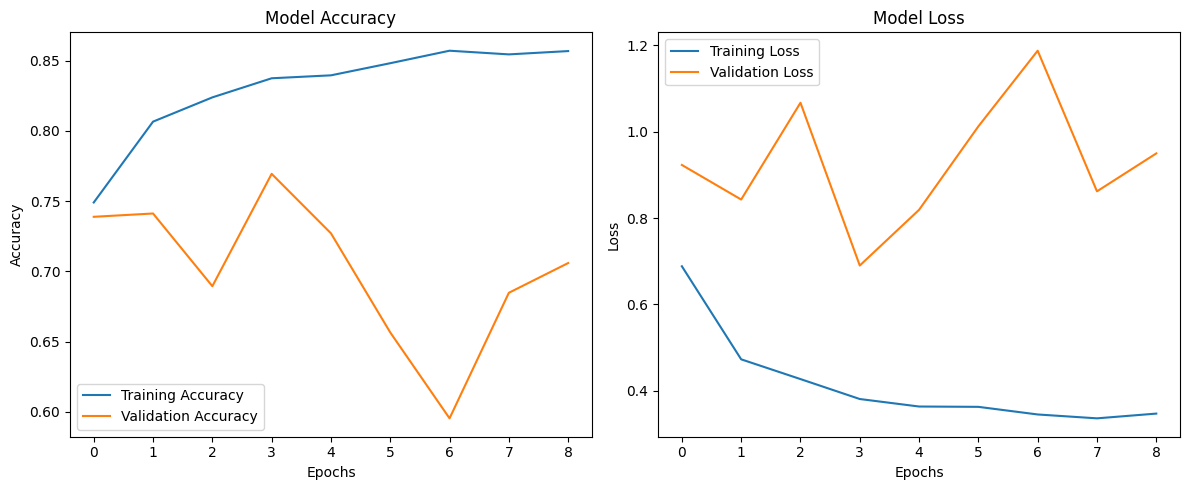

In [9]:
# Load all 4 folds of data from 100_stratified4fold_1000per_seed3888 as the training set
print("Loading training data...")
X_datas, y_datas = load_data("projectdata/images/100_stratified4fold_1000per_seed3888")



# Set training parameters
inception_full_params = {
    'epochs': 20,         # Increase training epochs
    'batch_size': 16,     # Batch size
    'learning_rate': 0.0005, # Learning rate
}

# Train InceptionV3 model and evaluate
print("Training InceptionV3 model and evaluating performance...")
inception_model, inception_history = train_full_model(
    X_datas=X_datas,
    y_datas=y_datas,
    model_func=create_inception_model,
    model_name="inception_v3",
    **inception_full_params
)



=== Q1 ===
Test set shape: (929, 224, 224, 3)
Label distribution in test set: (array([0, 1]), array([618, 311], dtype=int64))
30/30 [==============================] - 2s 52ms/step
Accuracy: 0.8924
Balanced Accuracy: 0.8528
F1 Score: 0.8897
Precision: 0.8986
Recall: 0.8924
Confusion Matrix:
[[601  15   2]
 [ 83 228   0]
 [  0   0   0]]

Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.88      0.97      0.92       618
       Tumor       0.94      0.73      0.82       311
       Empty       0.00      0.00      0.00         0

    accuracy                           0.89       929
   macro avg       0.61      0.57      0.58       929
weighted avg       0.90      0.89      0.89       929

Loading image: projectdata/metadata_code/GSM7780153_Post-Xenium_HE_Rep1.ome.tif
Image dimensions: (30786, 24241)
Number of data rows for Q1: 3551
Q1 region boundaries: (385, 248, 15393, 12120)
Accuracy: 0.8924
Balanced Accuracy: 0.8528
F1 Score: 0.8897
Prec

e:\Python3.10.11\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Q1 image dimensions: (15008, 11872)
Overlay count: 929 predictions displayed
Overlay count: 929 predictions displayed
Heatmap saved to inceptionv3_Q1_heatmap.png
Heatmap saved to inceptionv3_Q1_heatmap.png


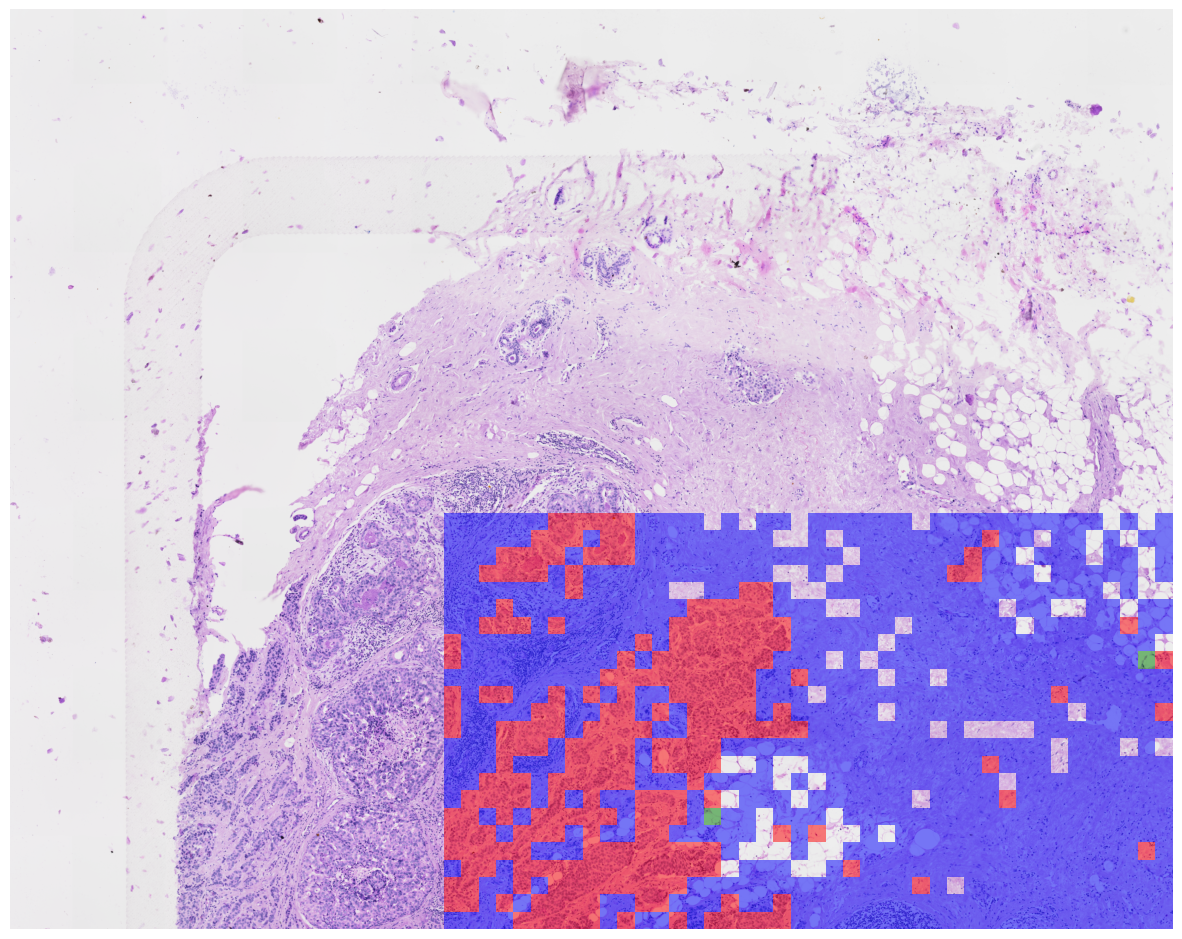


=== Q2 ===
Test set shape: (1021, 224, 224, 3)
Label distribution in test set: (array([0, 1]), array([745, 276], dtype=int64))
32/32 [==============================] - 2s 51ms/step
Accuracy: 0.8766
Balanced Accuracy: 0.8481
F1 Score: 0.8903
Precision: 0.9050
Recall: 0.8766
Confusion Matrix:
[[678  35  32]
 [ 58 217   1]
 [  0   0   0]]

Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.92      0.91      0.92       745
       Tumor       0.86      0.79      0.82       276
       Empty       0.00      0.00      0.00         0

    accuracy                           0.88      1021
   macro avg       0.59      0.57      0.58      1021
weighted avg       0.90      0.88      0.89      1021

Loading image: projectdata/metadata_code/GSM7780153_Post-Xenium_HE_Rep1.ome.tif
Image dimensions: (30786, 24241)
Number of data rows for Q2: 3551
Q2 region boundaries: (15778, 248, 30786, 12120)
Accuracy: 0.8766
Balanced Accuracy: 0.8481
F1 Score: 0.8903
P

e:\Python3.10.11\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Q2 image dimensions: (15008, 11872)
Overlay count: 1021 predictions displayed
Overlay count: 1021 predictions displayed
Heatmap saved to inceptionv3_Q2_heatmap.png
Heatmap saved to inceptionv3_Q2_heatmap.png


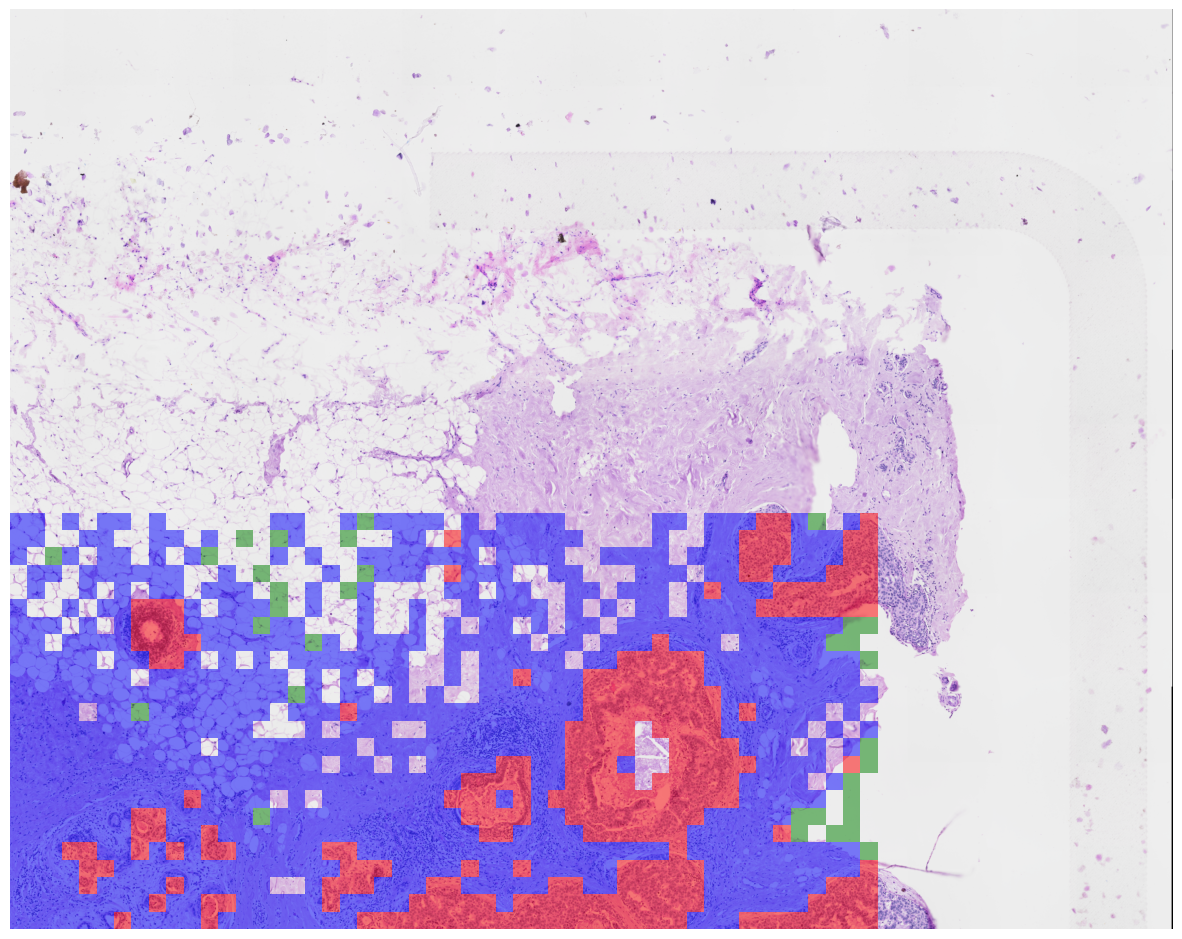


=== Q3 ===
Test set shape: (1718, 224, 224, 3)
Label distribution in test set: (array([0, 1]), array([ 441, 1277], dtype=int64))
54/54 [==============================] - 4s 62ms/step
Accuracy: 0.8452
Balanced Accuracy: 0.8617
F1 Score: 0.8558
Precision: 0.8853
Recall: 0.8452
Confusion Matrix:
[[ 395   34   12]
 [ 219 1057    1]
 [   0    0    0]]

Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.64      0.90      0.75       441
       Tumor       0.97      0.83      0.89      1277
       Empty       0.00      0.00      0.00         0

    accuracy                           0.85      1718
   macro avg       0.54      0.57      0.55      1718
weighted avg       0.89      0.85      0.86      1718

Loading image: projectdata/metadata_code/GSM7780153_Post-Xenium_HE_Rep1.ome.tif
Image dimensions: (30786, 24241)
Number of data rows for Q3: 3551
Q3 region boundaries: (385, 12369, 15393, 24241)
Accuracy: 0.8452
Balanced Accuracy: 0.8617
F1 Scor

e:\Python3.10.11\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Q3 image dimensions: (15008, 11872)
Overlay count: 1718 predictions displayed
Overlay count: 1718 predictions displayed
Heatmap saved to inceptionv3_Q3_heatmap.png
Heatmap saved to inceptionv3_Q3_heatmap.png


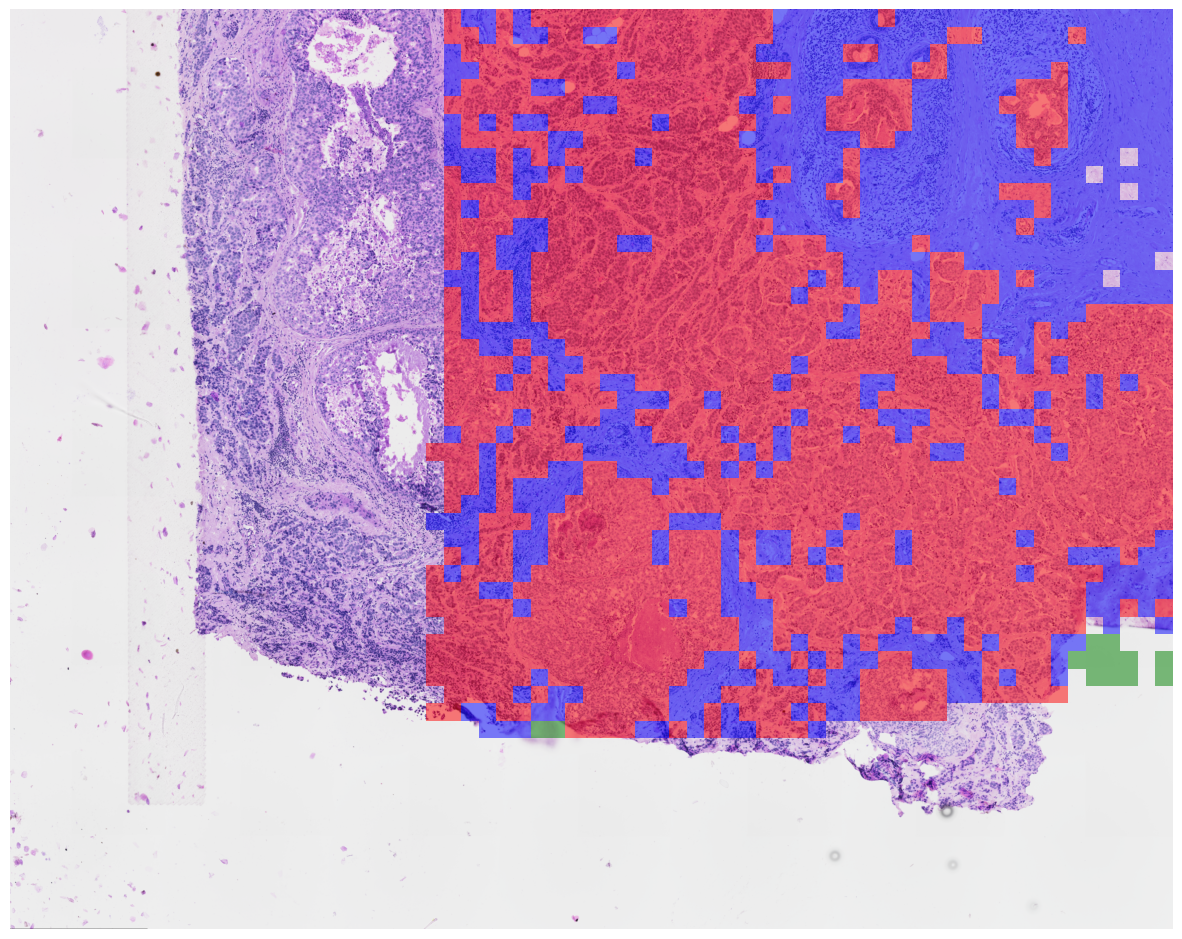


=== Q4 ===
Test set shape: (1799, 224, 224, 3)
Label distribution in test set: (array([0, 1]), array([1222,  577], dtype=int64))
57/57 [==============================] - 4s 59ms/step
Accuracy: 0.8416
Balanced Accuracy: 0.7915
F1 Score: 0.8482
Precision: 0.8708
Recall: 0.8416
Confusion Matrix:
[[1138   38   46]
 [ 196  376    5]
 [   0    0    0]]

Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.85      0.93      0.89      1222
       Tumor       0.91      0.65      0.76       577
       Empty       0.00      0.00      0.00         0

    accuracy                           0.84      1799
   macro avg       0.59      0.53      0.55      1799
weighted avg       0.87      0.84      0.85      1799

Loading image: projectdata/metadata_code/GSM7780153_Post-Xenium_HE_Rep1.ome.tif
Image dimensions: (30786, 24241)
Number of data rows for Q4: 3551
Q4 region boundaries: (15778, 12369, 30786, 24241)
Accuracy: 0.8416
Balanced Accuracy: 0.7915
F1 Sc

e:\Python3.10.11\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Q4 image dimensions: (15008, 11872)
Overlay count: 1799 predictions displayed
Overlay count: 1799 predictions displayed
Heatmap saved to inceptionv3_Q4_heatmap.png
Heatmap saved to inceptionv3_Q4_heatmap.png


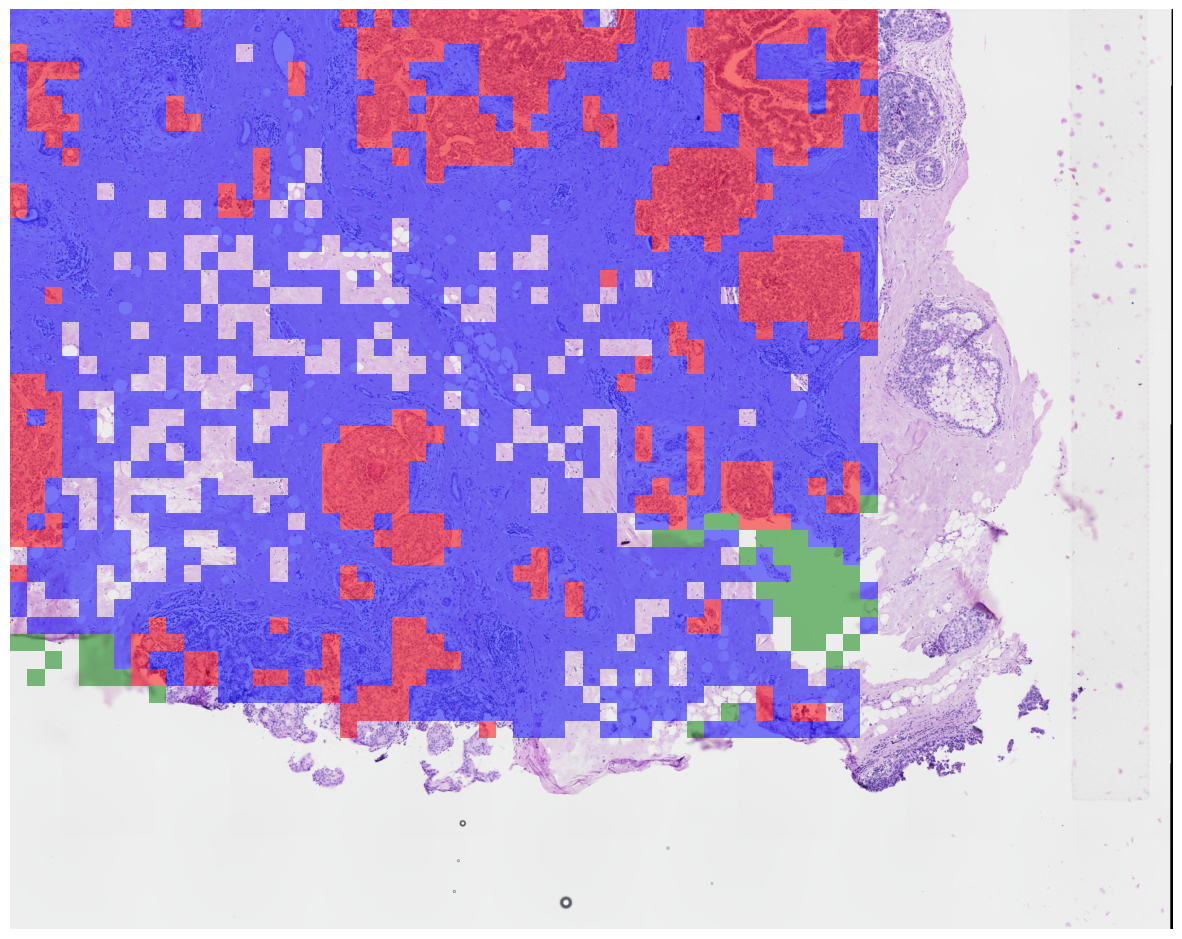

e:\Python3.10.11\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



==== OVERALL EVALUATION ACROSS ALL QUADRANTS ====
Total samples: 5467
Overall Accuracy: 0.8579
Overall Balanced Accuracy: 0.8493
Overall F1 Score: 0.8645
Overall Precision: 0.8814
Overall Recall: 0.8579
Overall Confusion Matrix:
[[2812  122   92]
 [ 556 1878    7]
 [   0    0    0]]

Overall Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.83      0.93      0.88      3026
       Tumor       0.94      0.77      0.85      2441
       Empty       0.00      0.00      0.00         0

    accuracy                           0.86      5467
   macro avg       0.59      0.57      0.58      5467
weighted avg       0.88      0.86      0.86      5467



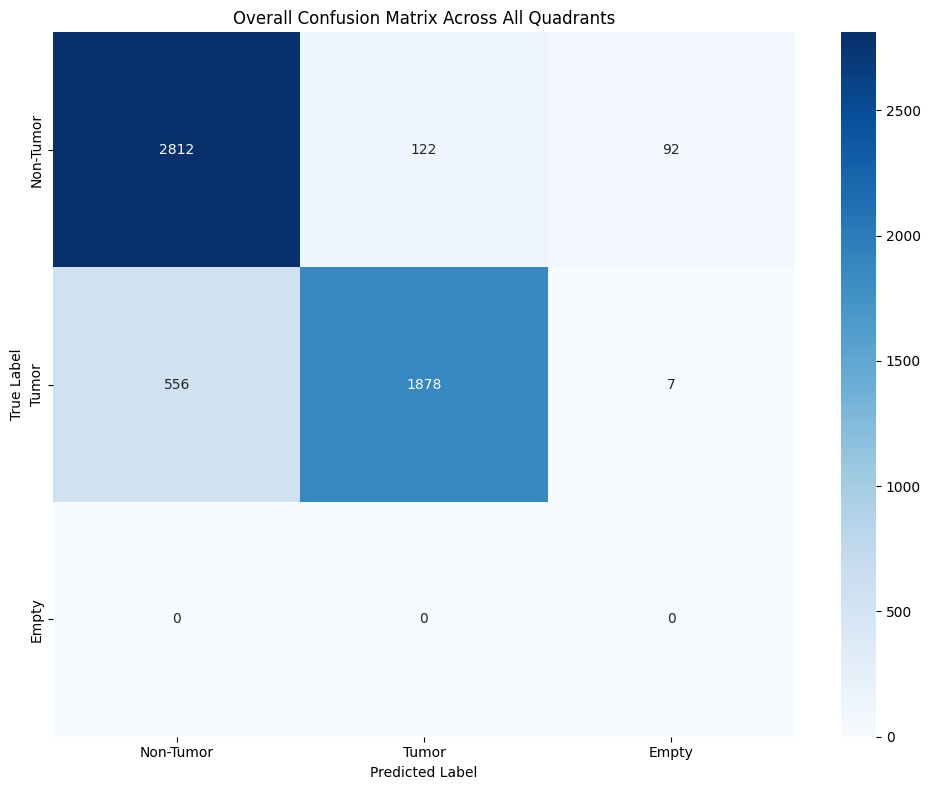

In [11]:
test_dir = "projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888_test"
metadata = pd.read_csv(os.path.join(test_dir, "grid_metadata.csv"))
big_image_path = 'projectdata/metadata_code/GSM7780153_Post-Xenium_HE_Rep1.ome.tif'

# Dictionary to store results from each quadrant
quadrant_results = {}

for quadrant in ['Q1', 'Q2', 'Q3', 'Q4']:
    X_ids, X_test, y_test = load_test_data(test_dir, quadrant)
    print(f"\n=== {quadrant} ===")
    result = evaluate_model(inception_model, X_test=X_test, y_test=y_test)
    quadrant_results[quadrant] = result
    
    result_q1 = create_flexible_heatmap(
        big_image_path=big_image_path,
        metadata=metadata,
        quadrant=quadrant,
        predictions=result['y_pred'],  
        grid_ids=X_ids,                
        save_path=f'inceptionv3_{quadrant}_heatmap.png',
        figsize=(15, 15),
        dpi=300,
        alpha=0.5,
        detail=False
    )

# Summarize results across all quadrants
overall_results = summarize_quadrant_results(quadrant_results)

## Training on the uncentered data, testing on the uncentered data

In [14]:
def quandrant_cv(X_datas, y_datas, model_func, epochs=10, batch_size=16, learning_rate=0.001):
    # Ensure input data is correct
    assert len(X_datas) == 4, "Need to provide X data for 4 quadrants"
    assert len(y_datas) == 4, "Need to provide y data for 4 quadrants"
    
    # Define quadrant names
    quadrant_names = ["Q1", "Q2", "Q3", "Q4"]
    
    # Save results
    results = {
        'accuracies': [],
        'f1_scores': [],
        'auc_scores': [],
        'confusion_matrices': [],
        'histories': [],
        'test_quadrants': [],
        'y_true': [],
        'y_pred': [],
        'y_prob': []
    }
    
    # Perform leave-one-out cross validation for each quadrant
    for test_idx in range(4):
        print(f"\n=== Fold {test_idx+1} Cross Validation - Test Quadrant: {quadrant_names[test_idx]} ===")
        
        # Select test set
        X_test = X_datas[test_idx]
        y_test = y_datas[test_idx]
        
        # Merge other three quadrants as training set
        train_indices = [i for i in range(4) if i != test_idx]
        X_train = np.concatenate([X_datas[i] for i in train_indices])
        y_train = np.concatenate([y_datas[i] for i in train_indices])
        
        # Convert to categorical labels
        y_train_cat = to_categorical(y_train, num_classes=3)
        y_test_cat = to_categorical(y_test, num_classes=3)
        
        print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
        print(f"Training set label distribution: {np.unique(y_train, return_counts=True)}")
        print(f"Test set label distribution: {np.unique(y_test, return_counts=True)}")
        
        # Create and train model
        model = model_func(
            learning_rate=learning_rate,
            seed=SEED
        )
        
        # Add early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train, y_train_cat,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)
        y_true = y_test
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate AUC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
            auc_score = auc(fpr, tpr)
        except:
            auc_score = 0
            
        # Save results
        results['accuracies'].append(accuracy)
        results['f1_scores'].append(f1)
        results['auc_scores'].append(auc_score)
        results['confusion_matrices'].append(cm)
        results['histories'].append(history)
        results['test_quadrants'].append(quadrant_names[test_idx])
        results['y_true'].append(y_true)
        results['y_pred'].append(y_pred)
        results['y_prob'].append(y_prob)
        
        # Output evaluation metrics for current fold
        print(f"\nCurrent fold ({quadrant_names[test_idx]} as test set):")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("Confusion Matrix:")
        print(cm)
        
        # Free memory
        K.clear_session()
        gc.collect()
        tf.compat.v1.reset_default_graph()
        
    # Calculate average metrics
    avg_accuracy = np.mean(results['accuracies'])
    avg_f1 = np.mean(results['f1_scores'])
    avg_auc = np.mean(results['auc_scores'])
    
    print("\n=== Cross Validation Summary ===")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average AUC: {avg_auc:.4f}")
    
    return results

In [15]:
X_datas, y_datas = load_data("projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888")


inception_full_params = {
    'epochs': 20,         
    'batch_size': 16,     
    'learning_rate': 0.0005, 
}

# Run Inception V3 cross validation
inception_cv_results = quandrant_cv(
    X_datas=X_datas,
    y_datas=y_datas,
    model_func=create_inception_model,
    **inception_full_params
)


=== Fold 1 Cross Validation - Test Quadrant: Q1 ===
Training set shape: (3300, 224, 224, 3), Test set shape: (1100, 224, 224, 3)
Training set label distribution: (array([0, 1, 2]), array([1500, 1500,  300], dtype=int64))
Test set label distribution: (array([0, 1, 2]), array([500, 500, 100], dtype=int64))
Epoch 1/20
165/165 [==============================] - 10s 47ms/step - loss: 0.5814 - accuracy: 0.8087 - val_loss: 0.5687 - val_accuracy: 0.8091
Epoch 2/20
165/165 [==============================] - 6s 35ms/step - loss: 0.4033 - accuracy: 0.8633 - val_loss: 0.7141 - val_accuracy: 0.7758
Epoch 3/20
165/165 [==============================] - 6s 35ms/step - loss: 0.3391 - accuracy: 0.8826 - val_loss: 0.7304 - val_accuracy: 0.7773
Epoch 4/20
165/165 [==============================] - 6s 35ms/step - loss: 0.3281 - accuracy: 0.8784 - val_loss: 0.9688 - val_accuracy: 0.7485
Epoch 5/20
165/165 [==============================] - 6s 35ms/step - loss: 0.2859 - accuracy: 0.8932 - val_loss: 0.6019 

In [ ]:
def generate_classification_reports(results):
    """Generate classification reports for each test quadrant"""
    for i, quadrant in enumerate(results['test_quadrants']):
        print(f"\n=== Classification Report for Test Quadrant: {quadrant} ===")
        print(classification_report(results['y_true'][i], results['y_pred'][i], 
                                   target_names=['Non-Tumor', 'Tumor', 'Empty'],
                                   zero_division=0))
        
def evaluate_overall_performance(results):
    """Evaluate the overall performance by combining all quadrants"""
    # 合并所有象限的真实标签和预测标签
    all_true = np.concatenate(results['y_true'])
    all_pred = np.concatenate(results['y_pred'])
    
    # 计算总体性能指标
    overall_accuracy = accuracy_score(all_true, all_pred)
    overall_balanced_acc = balanced_accuracy_score(all_true, all_pred)
    overall_f1 = f1_score(all_true, all_pred, average='weighted')
    overall_precision = precision_score(all_true, all_pred, average='weighted', zero_division=0)
    overall_recall = recall_score(all_true, all_pred, average='weighted', zero_division=0)
    overall_cm = confusion_matrix(all_true, all_pred)
    
    # 打印总体性能指标
    print("\n=== 总体表现评估（所有象限合并）===")
    print(f"样本总数: {len(all_true)}")
    print(f"准确率 (Accuracy): {overall_accuracy:.4f}")
    print(f"平衡准确率 (Balanced Accuracy): {overall_balanced_acc:.4f}")
    print(f"F1分数 (F1 Score): {overall_f1:.4f}")
    print(f"精确率 (Precision): {overall_precision:.4f}")
    print(f"召回率 (Recall): {overall_recall:.4f}")
    print("\n总体混淆矩阵 (Overall Confusion Matrix):")
    print(overall_cm)
    print("\n总体分类报告 (Overall Classification Report):")
    print(classification_report(all_true, all_pred, 
                              target_names=['Non-Tumor', 'Tumor', 'Empty'],
                              zero_division=0))
    
    # 可视化总体混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Tumor', 'Tumor', 'Empty'], 
                yticklabels=['Non-Tumor', 'Tumor', 'Empty'])
    plt.xlabel('预测标签 (Predicted Label)')
    plt.ylabel('真实标签 (True Label)')
    plt.title('总体混淆矩阵 (Overall Confusion Matrix)')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': overall_accuracy,
        'balanced_accuracy': overall_balanced_acc,
        'f1_score': overall_f1,
        'precision': overall_precision,
        'recall': overall_recall,
        'confusion_matrix': overall_cm,
        'y_true': all_true,
        'y_pred': all_pred
    }

generate_classification_reports(inception_cv_results)
print("\n现在评估四个象限合并后的总体表现:")
overall_performance = evaluate_overall_performance(inception_cv_results)


=== Classification Report for Test Quadrant: Q1 ===
              precision    recall  f1-score   support

   Non-Tumor       0.93      0.85      0.89       500
       Tumor       0.86      0.94      0.90       500
       Empty       0.99      1.00      1.00       100

    accuracy                           0.90      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.90      0.90      0.90      1100


=== Classification Report for Test Quadrant: Q2 ===
              precision    recall  f1-score   support

   Non-Tumor       0.87      0.80      0.83       500
       Tumor       0.83      0.89      0.86       500
       Empty       0.88      0.98      0.92       100

    accuracy                           0.85      1100
   macro avg       0.86      0.89      0.87      1100
weighted avg       0.86      0.85      0.85      1100


=== Classification Report for Test Quadrant: Q3 ===
              precision    recall  f1-score   support

   Non-Tumor       0.87 